### Scanpy Integration
Trying to integrate [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html) into scRNA-seq processing workflow.  
Testing out simple read-write, dimension reduction, and visualization with basic Scanpy tools.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [5]:
retina = sc.read('../inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz')

Only considering the two last: ['.tsv', '.gz'].
Only considering the two last: ['.tsv', '.gz'].


In [17]:
retina.shape

(1326, 20478)

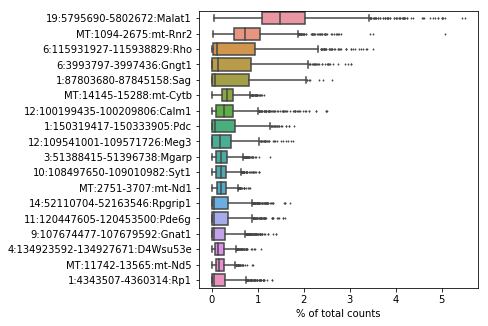

In [16]:
sc.pl.highest_expr_genes(retina, n_top=18)

In [18]:
sc.pp.filter_cells(retina, min_genes=200)
sc.pp.filter_genes(retina, min_cells=3)
retina.shape

(1326, 15559)

In [19]:
# calculate % mitochondrial expression per cell
mito_genes = retina.var_names.str.contains(':mt-')
retina.obs['percent_mito'] = np.sum(retina[:, mito_genes].X, axis=1) / np.sum(retina.X, axis=1)

# total counts per cell as annotation
retina.obs['n_counts'] = retina.X.sum(axis=1)

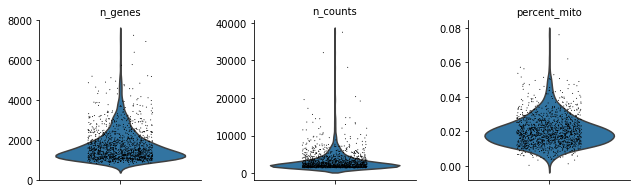

In [20]:
sc.pl.violin(retina, ['n_genes','n_counts','percent_mito'], jitter=0.2, multi_panel=True)

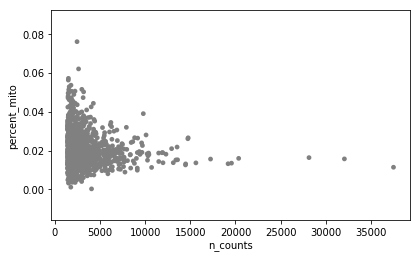

In [21]:
sc.pl.scatter(retina, x='n_counts', y='percent_mito')

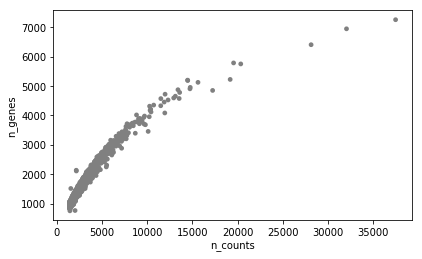

In [22]:
sc.pl.scatter(retina, x='n_counts', y='n_genes')

In [23]:
retina

AnnData object with n_obs × n_vars = 1326 × 15559 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [24]:
# do some filtering using the metadata above
retina = retina[retina.obs['percent_mito'] < 0.05, :]

In [25]:
# total-count normalize (lib size correct) to 10k reads per cell
sc.pp.normalize_per_cell(retina, counts_per_cell_after=10000)

Trying to set attribute `.obs` of view, making a copy.


In [27]:
sc.pp.log1p(retina) # log-transform counts
retina.raw = retina # set normalized data matrix as 'relevant data' for visualization and DE testing

In [28]:
sc.pp.highly_variable_genes(retina, min_mean=0.0125, max_mean=3, min_disp=0.5)

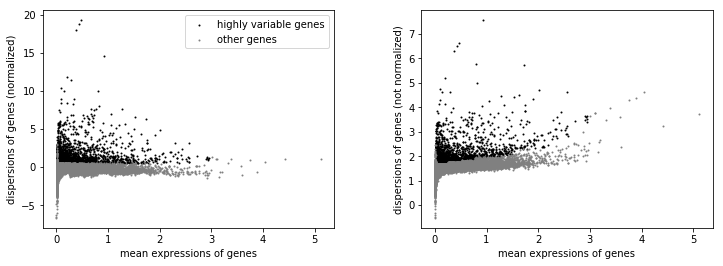

In [29]:
sc.pl.highly_variable_genes(retina)

In [30]:
# filter for HVGs
retina = retina[:, retina.var['highly_variable']]

In [31]:
# remove effects of total counts and % mito expr
sc.pp.regress_out(retina, ['n_counts', 'percent_mito'])

In [32]:
# scale data to unit variance
sc.pp.scale(retina, max_value=10)

In [33]:
sc.tl.pca(retina)

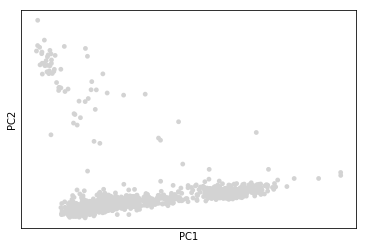

In [34]:
sc.pl.pca(retina)

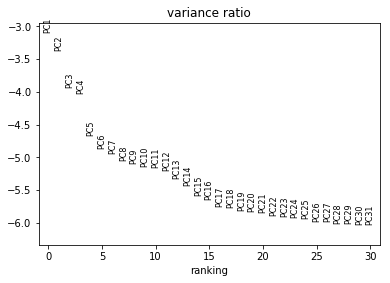

In [35]:
sc.pl.pca_variance_ratio(retina, log=True)

In [36]:
retina

AnnData object with n_obs × n_vars = 1315 × 2645 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [37]:
sc.pp.neighbors(retina, n_neighbors=30, n_pcs=30)

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/umap/umap_.py:328: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.6/site-packages/umap/umap_.py", line 446:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.6/site-packages/umap/umap_.py", line 329:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/numba/compile

In [39]:
sc.tl.paga(retina)
sc.pl.paga(retina)
sc.tl.umap(retina, init_pos='paga')

DeprecationWarning: To avoid name collision with the igraph project, this visualization library has been renamed to 'jgraph'. Please upgrade when convenient.